In [1]:
import unicodedata
import collections
import random
import warnings
import cv2
import os

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont,ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
#warnings.filterwarnings("ignore", "FutureWarning")
get_ipython().run_line_magic('matplotlib', 'inline')


In [3]:
# Глобальные константы
# Символы
RUS_LETTERS = 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
NUMBERS = '0123456789'
PUNCTUATION_MARKS = ' .,?:;—!<>-«»()[]*"'
ALL_SYMBOLS = RUS_LETTERS + NUMBERS + PUNCTUATION_MARKS

# Пути
raw_data_path ='raw_data/russian_news_corpus/'
source_file = 'russian_news.txt'
save_label_path = 'raw_data/synth_dataset/'
save_img_path = 'raw_data/synth_dataset/images/'
fonts_path = 'raw_data/fonts/'

# Шрифты
font_avg = 20

# Ширина генерируемых картинок
width =360
height = 32

max_i = 30

# Количество генерируемых картинок в датасете
img_amount = 20


noise_lvl = 0.8

# Флаг для шумного фона картинки
noisy_back = True

# Флаг для пробельного разделения букв
letter_sep  = True

In [7]:
# Максимальное кол-ва символов, вмещающихся в заданную ширину картинки 
def get_max_i(width,font,symbols=ALL_SYMBOLS)-> int:
    max_w_char = 0
    for char in symbols:
        if font.getlength(char) > max_w_char:
            max_w_char = font.getlength(char)
    max_i = round(width/max_w_char)-1
    return max_i


# (Минимально) допустимая высота картинки 
def get_height(font,symbols=ALL_SYMBOLS) -> int:
    return font.getbbox(symbols)[3]+6


# Проверка на распознаваемость:
# Критерии:
# 1: все символы из набора symbols
# 2: есть хотя бы одна буква/цифра
# 3: есть хотя бы два непробельных символа
def is_applicable(text,symbols=ALL_SYMBOLS) -> bool:
    cond1 = all(element in symbols for element in text)
    cond2 = any(element in (RUS_LETTERS+NUMBERS) for element in text)
    cond3 = len(text) > 1
    return cond1 and cond2


def fit_to_frame (line , width , font):
    margins = 5
    l = len(line)
    for i in range(l):
        text = line[:l-i]
        if font.getbbox(text)[2]+margins*2 <= width:
            break       
    return text


def generate_words(line, width, font):
    first_space = line.find(' ')
    text = line[first_space:]
    
    text = fit_to_frame (text , width , font)
    
    last_space = text.rfind(' ')
    text = text[:last_space]
    return text


def generate_sep_letters(line, width, font):
    text = ''
    for ch in line:
        text = text + ch + ' '
    text = fit_to_frame (text , width , font)
    return text
    

# Генериует шумный фон: случайно заполняет картинку (зависит от alpha) серыми пикселями 
def generate_noisy_background(width :int, height : int, alpha : float = 0.5) ->Image:
    w= random.randint(200, 255)
    im = Image.new('L', (width, height), color = (w, ))
    for i in range( round(im.size[0]*im.size[1]*alpha) ):
        im.putpixel(
        (random.randint(0, im.size[0]-1), random.randint(0, im.size[1]-1)),
        (random.randint(0,255))
      )
    im = im.filter(ImageFilter.BoxBlur(5))
    return im


def draw_text(img,text,font):
    b = random.randint(0, 100)
    blur = 2.0*random.random()
    drawing = ImageDraw.Draw(img)
    drawing.text((5, 5), text, font=font, fill=(b,))
    img = img.filter(ImageFilter.BoxBlur(blur))
    return img

In [5]:
# Создадим список возможных шрифтов
ftp = os.listdir(fonts_path)
dispersion = 2
fonts = []
for f in ftp:
    for size in range (font_avg-dispersion, font_avg+dispersion+1):
        font = ImageFont.truetype(fonts_path+f, size)
        fonts.append(font)



In [8]:
№max_i = get_max_i(width,font,ALL_SYMBOLS)
№height = get_height(font,ALL_SYMBOLS)
№print(max_i, height)

18 32


In [6]:
labels = [] 
i = 0
#filler = ' '*max_i


with open(raw_data_path+source_file, 'r', encoding="utf-8") as f:
    while i < img_amount :
        line = f.read(max_i)
        
        # Проверка на отсутствие сторонних символов
        if is_applicable(line):
            i+=1
            font = random.choice(fonts)
            if letter_sep:
                text = generate_sep_letters(line, width, font)
            else:
                text = generate_words(line, width, font)

            text = text.upper()
            if noisy_back:
                img = generate_noisy_background(width, height, 
                                                noise_lvl *random.random()) 
            else :
                w = random.randint(200, 255)
                img = Image.new('L', (width, height), color = (w, ))
                
            img = draw_text(img, text ,font)
            img_name = f'{i}_pasp.png'
            img.save(save_img_path + img_name)
            labels.append(img_name + ' : '+ text)
            
            
#print (labels [0])
            
with open(save_label_path + 'labels.txt', 'w') as f:
    for element in labels:
        f.write(element)
        f.write('\n')

In [6]:
labels = [] 
i = 0
filler = ' '*max_i
noise_lvl = 0.8


with open(raw_data_path+source_file, 'r', encoding="utf-8") as f:
    while i < img_amount :
        line = f.read(max_i)
        # Возьмем целые слова из прочитанной строки
        first_space = line.find(' ')
        last_space = line.rfind(' ')
        line = line[first_space:last_space]
        
        # Проверка на отсутствие сторонних символов
        if is_applicable(line):
            i+=1
            line = (line + filler)[0:max_i]
            w = random.randint(200, 255)
            b = random.randint(0, 100)
            blur = 2.0*random.random()
            font_s = font_size + 2 - random.randint(0, 4)
            font1 = ImageFont.truetype('raw_data/fonts/Roboto-Regular.ttf', font_s)
            
            #line = line.upper()
            if noisy_back:
                img = generate_noisy_background(width, height, 
                                                noise_lvl *random.random()) 
            else :
                img = Image.new('L', (width, height), color = (w, ))
                
            drawing = ImageDraw.Draw(img)
            drawing.text((5, 5), line, font=font1, fill=(b,))
            
            img = img.filter(ImageFilter.BoxBlur(blur))
            img_name = f'{i}_pasp.png'
            img.save(save_img_path + img_name)
            labels.append(img_name + ' : '+ line)
            
#print (labels [0])
            
with open(save_label_path + 'labels.txt', 'w') as f:
    for element in labels:
        f.write(element)
        f.write('\n')

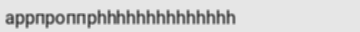

In [22]:
w = random.randint(230, 255)
b = random.randint(0, 100)
font_s = font_size + 2 - random.randint(0, 4)
font1 = ImageFont.truetype('raw_data/fonts/Roboto-Regular.ttf', font_s)
line = 'аррпроппрhhhhhhhhhhhhhh'
# созадим картинку: символы в строке в один ряд
img = Image.new('L', (width, height), color = (w, ))
#img = img.filter(gaussian_filter)
drawing = ImageDraw.Draw(img)
drawing.text((5, 5), line, font=font1, fill=(0,))
img = img.filter(ImageFilter.BoxBlur(1))
#type(img)
img

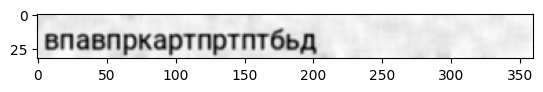

In [41]:
w = random.randint(230, 255)


img = Image.new('L', (width, height), color = (w, ))
im = img
for i in range( round(im.size[0]*im.size[1]/10) ):
    im.putpixel(
    (random.randint(0, im.size[0]-1), random.randint(0, im.size[1]-1)),
    (random.randint(0,255))
  )

#im = im.convert('L')
line = 'впавпркартпртптбьд'
drawing = ImageDraw.Draw(im)
#drawing.text((5, 5), line, font=font, fill=(0,))
im = im.filter(ImageFilter.BoxBlur(5))
#im = im.filter(gaussianFilter)
im = draw_text(im,line,font)
plt.imshow(im, cmap='gray')
plt.show()


In [13]:
with open(raw_data_path+source_file, 'r', encoding="utf-8") as f:
    line = f.read(40)
    print( line)

весть.ru: мид еще раз напоминать, что ро


In [15]:
a = 'dt ff f4 '
a.replace(' ','')

'dtfff4'

In [32]:
foo = ['1','2','3','4']
random.choice(foo)

'2'

In [ ]:
def bgremove2(myimage):
    # First Convert to Grayscale
    #myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    ret,baseline = cv2.threshold(myimage,127,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Convert black and white back into 3 channel greyscale
    #background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    return finalimage  